In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from string import punctuation

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df_true=pd.read_csv('DataSet_Misinfo_TRUE.csv')
df_fake=pd.read_csv('DataSet_Misinfo_FAKE.csv')

In [4]:
df_true['label']=1
df_true=df_true.drop('Unnamed: 0',axis=1)
df_true.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [5]:
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)
df_fake.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [6]:
df=pd.concat([df_true,df_fake])

In [7]:
df=df.dropna(how="any")

In [8]:
df.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [12]:
stop = list(set(stopwords.words('english'))) + list(punctuation) + ['“','’', '“', '”', '‘','...']

def lowerizer(article):
    return article.lower()

def remove_html(article):
    article = re.sub("()", "", article, flags=re.DOTALL)
    return article

def remove_url(article):
    article = re.sub(r'https?:\/\/.\S+', "", article)
    return article

def remove_hashtags(article):
    article = re.sub("#"," ",article)
    return article

def remove_a(article):
    article = re.sub("@"," ",article)
    return article

def remove_brackets(article):
    article = re.sub('\[[^]]*\]', '', article)
    return article

def remove_stop_punct(article):
    final_article = []
    for i in article.split():
        if i not in stop:
            final_article.append(i.strip())
    return " ".join(final_article)

def remove_numbers(article):
    article = re.sub('[0-9]*', '', article)
    return article

def preprocessing(article):
    article = lowerizer(article)
    article = remove_html(article)
    article = remove_url(article)
    article = remove_hashtags(article)
    article = remove_a(article)
    article = remove_brackets(article)
    article = remove_stop_punct(article)
    article = remove_numbers(article)
    return article

In [13]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(lambda x : preprocessing(x))

100%|██████████| 78588/78588 [01:12<00:00, 1079.70it/s] 


In [14]:
df.head()

,text,label
0,head conservative republican faction u.s. cong...,1
1,transgender people allowed first time enlist u...,1
2,special counsel investigation links russia pre...,1
3,trump campaign adviser george papadopoulos tol...,1
4,president donald trump called u.s. postal serv...,1


In [16]:
df.to_csv('C:/Users/natas/NN_projects/FakeNews/processed_df.csv', sep= ',')

In [3]:
# df = pd.read_csv('processed_df.csv')
# df=df.drop('Unnamed: 0',axis=1)
# df=df.dropna(how="any")

In [17]:
cv = CountVectorizer(max_features=15000, ngram_range=(1, 1))
sparse_matrix = cv.fit_transform(df['text']).toarray()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(df['label']))

In [27]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(15000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [29]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [46]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

In [31]:
epochs = 40
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()

Epoch: 1, Loss: 0.6883421540260315, Accuracy: 55.44697189331055%
Epoch: 2, Loss: 0.6324004530906677, Accuracy: 68.05110168457031%
Epoch: 3, Loss: 0.7926671504974365, Accuracy: 55.453758239746094%
Epoch: 4, Loss: 0.5449404716491699, Accuracy: 82.36881256103516%
Epoch: 5, Loss: 0.48670414090156555, Accuracy: 86.01143646240234%
Epoch: 6, Loss: 0.43608540296554565, Accuracy: 86.94457244873047%
Epoch: 7, Loss: 0.378201961517334, Accuracy: 89.2027587890625%
Epoch: 8, Loss: 0.363481342792511, Accuracy: 89.75415802001953%
Epoch: 9, Loss: 0.31353259086608887, Accuracy: 90.83829498291016%
Epoch: 10, Loss: 0.2993718981742859, Accuracy: 90.76703643798828%
Epoch: 11, Loss: 0.25864338874816895, Accuracy: 92.56544494628906%
Epoch: 12, Loss: 0.2414226233959198, Accuracy: 93.30856323242188%
Epoch: 13, Loss: 0.22305454313755035, Accuracy: 93.72762298583984%
Epoch: 14, Loss: 0.19922858476638794, Accuracy: 94.1721420288086%
Epoch: 15, Loss: 0.19264888763427734, Accuracy: 94.01605224609375%
Epoch: 16, Loss

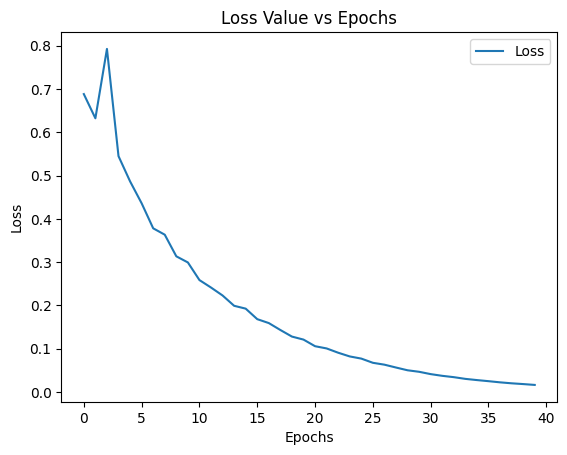

In [32]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [33]:
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

In [34]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred//len(x_test)))

Accuracy : 95%


In [51]:
import pickle

with open('saved/model_and_cv.pkl', 'wb') as f:
    pickle.dump((model, cv), f)

In [79]:
def predict(news):
    
    news = preprocessing(news)
    news = [news]
    
    with open('saved/model_and_cv.pkl', 'rb') as f:
        model, cv = pickle.load(f)
        
    BoW_array = cv.transform(news).toarray()
    Bow_tensor = torch.from_numpy(BoW_array).float()
    
    model.eval()
    with torch.no_grad():
        output = model(Bow_tensor)
        prob = torch.argmax(output,dim=1)
    print(prob.item())
    

In [80]:
# TRUE
predict('A federal judge in Seattle partially blocked U.S. President Donald Trump’s newest restrictions on refugee admissions on Saturday, the latest legal defeat for his efforts to curtail immigration and travel to the United States. The decision by U.S. District Judge James Robart is the first judicial curb on rules the Trump administration put into place in late October that have contributed significantly to a precipitous drop in the number of refugees being admitted into the country. Refugees and groups that assist them argued in court that the administration’s policies violated the Constitution and federal rulemaking procedures, among other claims. Department of Justice attorneys argued in part that U.S. law grants the executive branch the authority to limit refugee admissions in the way that it had done so. On Oct. 24, the Trump administration effectively paused refugee admissions from 11 countries mostly in the Middle East and Africa, pending a 90-day security review, which was set to expire in late January. The countries subject to the review are Egypt, Iran, Iraq, Libya, Mali, North Korea, Somalia, South Sudan, Sudan, Syria and Yemen. For each of the last three years, refugees from the 11 countries made up more than 40 percent of U.S. admissions. A Reuters review of State Department data showed that as the review went into effect, refugee admissions from the 11 countries plummeted. Robart ruled that the administration could carry out the security review, but that it could not stop processing or admitting refugees from the 11 countries in the meantime, as long as those refugees have a “bona fide” connection to the United States. As part of its new restrictions, the Trump administration had also paused a program that allowed for family reunification for refugees, pending further security screening procedures being put into place. Robart ordered the government to re-start the program, known as “follow-to-join”. Approximately 2,000 refugees were admitted into the United States in fiscal year 2015 under the program, according to Department of Homeland Security data. Refugee advocacy groups praised Robart’s decision.  “This ruling brings relief to thousands of refugees in precarious situations in the Middle East and East Africa, as well as to refugees already in the U.S. who are trying to reunite with their spouses and children,” said Mariko Hirose, litigation director for the International Refugee Assistance Project, one of the plaintiffs in the case. A Justice Department spokeswoman, Lauren Ehrsam, said the department disagrees with Robart’s ruling and is “currently evaluating the next steps”. Robart, who was appointed to the bench by Republican former President George W. Bush, emerged from relative obscurity in February, when he issued a temporary order to lift the first version of Trump’s travel ban. On Twitter, Trump called him a “so-called judge” whose “ridiculous” opinion “essentially takes law-enforcement away from our country”. Robart’s ruling represented the second legal defeat in two days for the Trump administration. On Friday, a U.S. appeals court said Trump’s travel ban targeting six Muslim-majority countries should not be applied to people with strong U.S. ties, but said its ruling would be put on hold pending a decision by the U.S. Supreme Court')

1


In [82]:
# FAKE
predict("New questions are being asked about President Donald Trump s ability to lead after he slurred his words during a speech about his Jerusalem decision. Possible reasons for this include: fatigue, a dry mouth (the White House explanation), the use of drugs or alcohol, a problem with his dentures or more troubling issues dealing with his mental or physical health. Morning Joe reported this morning that, unlike other presidents, Trump has opted not to get his physicals at the Walter Reed Army Medical Center.Questions about Trump s mental stability have been growing over the last few months. While he has never been viewed as a stable person in the traditional sense, his tweets and comments have gotten more erratic. He was widely criticized recently when he retweeted several anti-Muslim videos that were posted by radicals in the United Kingdom.One psychiatrist talk to MSNBC s Lawrence O Donnel about his impressions of Trump s state of mind.Many think that any degradation in Trump s mental state may be due to the increased pressure he is feeling from Robert Mueller s investigations into collusion between his campaign and the Russian government. This has increased since former National Security Advisor Michael Flynn pleaded guilty to lying to the FBI.All of this talk is leading to more people to ask if Trump should be removed from office, citing the 25th Amendment to the U.S. Constitution. Rep. Jamie D. Raskin (D-MD) has circulated a  dear colleague  letter suggesting just that. As published in the Washington Post, it says: Please join a rapidly growing group of colleagues in cosponsoring H.R. 1987, the Oversight Commission on Presidential Capacity Act. It sets up and defines the Congressionally-appointed  body  called for by the 25th Amendment. Under Section 4 of the 25th Amendment, the Vice-President and a majority of the Cabinet or the Vice-President and a majority of  such other body as Congress may by law provide  can determine that the President is for reasons of physical or mental incapacity unable to discharge the powers and duties of his office. The 25th Amendment was added to the Constitution in 1967, but in the last 50 years Congress never created the  body  that its language contemplated. Perhaps it never occurred to prior Congresses that setting up this body was necessary. For obvious reasons, it is indeed necessary, and now is the time for us to do it. While the Republicans in the Cabinet and Congress may not yet be ready to take this step, it is out there.Featured image via Andrew Burton/Getty Images")

0
